In [1]:
def composition_CxHyOz_Air(gas, fuel_species,fracc_fuel, exceso_aire):
    #Reactivos de la reaccion 
    iFuel=np.zeros(len(fuel_species))
    C_atoms=0
    H_atoms=0
    O_atoms=0
    X = np.zeros(gas.n_species)
    for i in range(len(fuel_species)):
        iFuel[i]=gas.species_index(fuel_species[i])
        C_atoms=C_atoms+gas.n_atoms(fuel_species[i], 'C')*fracc_fuel[i]
        H_atoms=H_atoms+gas.n_atoms(fuel_species[i], 'H')*fracc_fuel[i]
        O_atoms=O_atoms+gas.n_atoms(fuel_species[i], 'O')*fracc_fuel[i]
        X[gas.species_index(fuel_species[i])]=fracc_fuel[i]
    iO2 = gas.species_index('O2') #Busca el indice del O2
    iN2 = gas.species_index('N2') #Busca el indice del N2 
    stoich_O2 = C_atoms + H_atoms/4.0 - O_atoms/2.0 #Encuentro las moles estequiometricas de oxigeno
    X[iO2] = stoich_O2*exceso_aire #Le asigno el num. de moles a la componente de oxigeno del aire 
    X[iN2] = (79/21)*stoich_O2*exceso_aire #Le asigno el num. de moles a la componente de nitrogeno del aire
    #Mismo metodo pero para los productos
    iCO2=gas.species_index('CO2')
    iH2O=gas.species_index('H2O')
    iN2=gas.species_index('N2')
    X_prod = np.zeros(gas.n_species)
    X_prod[iCO2]=C_atoms
    X_prod[iH2O]=H_atoms/2
    X_prod[iN2]=(79/21)*stoich_O2*exceso_aire
    X_reac_prod=[X,X_prod]
    Moles_Prod=[C_atoms,H_atoms/2,(79/21)*stoich_O2*exceso_aire]
    return X_reac_prod,C_atoms,H_atoms,stoich_O2,Moles_Prod

# Cantera Example: Heating values
## Poder calorífico de la mezcla ($90\%C_{12}H_{26}+10\%H_2$)
La combustión completa de la mezcla sigue la siguiente reacción:
<br>
$(0.9C_{12}H_{26}+0.1H_2)+a(O_2+3.76N_2)\rightarrow bCO_2+cH_2O+dN_2$

$C: 0.9(12)=b$

$H: 0.9(26)+0.1(2)=c(2)$

$O: a(2)=b(2)+c$

$N: a(3.76)(2)=d(2)$

Luego de iterar, se obtiene que:
<br>
$a=16.7 \quad b= 10.8 \quad c=11.8 \quad d=62.79$

$(0.9C_{12}H_{26}+0.1H_2)+16.7(O_2+3.76N_2)\rightarrow 10.8CO_2+11.8H_2O+62.79N_2$

We compute the lower heating value (LHV) as the difference in enthalpy (per kg *mixture*) between reactants and products at constant temperature and pressure, divided by the mass fraction of fuel in the reactants

In [10]:

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

#----------------------------------------------------
#  DEFINICIÓN COMBUSTIBLE Y EL ESTADO DE REFERENCIA
#----------------------------------------------------

#Primero se definen las especies y fracciones de la mezcla de combustible
fuel_species =  ['c12h26','h2'] 
fracc_fuel =[0.9,0.1]
#Se establecen las especies presentes en los productos
prod_species = ['co2','h2o','n2']
#Se establece el estado termodinamico
temp=298.6 #K
press=1*ct.one_atm #Pa 
exceso_aire=1

#Se crea una mezcla de gases referentes a los productos y reactivos.
gas1 = ct.Solution('nDodecane_Reitz.cti', 'nDodecane_IG') #Equivalente a los reactivos
gas2 = ct.Solution('nDodecane_Reitz.cti', 'nDodecane_IG')#Equivalente a los productos
#Se extraen las composiciones molares
comp_react_prod,x,y,a,Moles_Prod=composition_CxHyOz_Air(gas1, fuel_species,fracc_fuel, exceso_aire) #LLama la funcion y guarda el vector 
gas1.TPX = temp, press, comp_react_prod[0]
gas2.TPX = None, None, comp_react_prod[1]

#Se imprime la reacción resultante 
print("La reaccion estequimetrica es igual a:\n",x,"C",y,"H + ",a,"(O2+3.76N2) ----> ",Moles_Prod[0],"CO2 + ",Moles_Prod[1],"H20 + ",Moles_Prod[2],"N2" )

#Masa molecular combustible [kg/kmol]
Masa_Mol_Fuel=0
for i in range(len(fuel_species)):
    Masa_Mol_Fuel=gas1[fuel_species[i]].molecular_weights*fracc_fuel[i]+Masa_Mol_Fuel #kg/kmol
#------------------------------------------
#            PODER CALORIFICO
#------------------------------------------
#    -----------------------------------
#        Entalpia Formacion Reactivos
#    -----------------------------------

h1_mole = gas1.enthalpy_mole #Entalpia de formacion la mezcla aire combustible molar

#A partir de la entalpia de formacion de la mezcla total, es necesario encontrar la del combustible 
 #En otras palabras, pasar de [kJ/kmolaire+fuel] a [kJ/kmolfuel]

#Para hallar la entalpia de formacion de los reactivos
 #Encontrar la fraccion molar de los reactivos
frac_molar_fuel=0
for i in range(len(fuel_species)):
    frac_molar_fuel=gas1[fuel_species[i]].X+frac_molar_fuel

h1_mole_fuel=h1_mole/(frac_molar_fuel*1e6) # [MJ/kmolfuel]

#    -----------------------------------
#        Entalpia Formacion Productos 
#    -----------------------------------

h2_mole = gas2.enthalpy_mole*sum(Moles_Prod)/(1e6) #MJ/kmolfuel

#    -------------------------------------------------------
#      Poder Calorifico Inferior Molar Masico Volumetrico
#    -----------------------------------------------------
def Vst(moles):
    Tst=288.6 #K
    Pst=101.3 #kPa
    Ru= 8.31447 #kJ/molK
    Vst=(moles*Ru*Tst)/Pst
    return (Vst)

LHV_molar=-(h2_mole-h1_mole_fuel) #[MJ/kmol]
LHV_masico=LHV_molar/Masa_Mol_Fuel #[MJ/kg]
LHV_vol=LHV_molar/Vst(1)  #[MJ/m3]

#    -------------------------------------------------------
#      Poder Calorifico Superior Molar Masico Volumetrico
#    -----------------------------------------------------

#Para hallar el poder calorífico superior
water = ct.Water()
# Se establece el estado líquido del agua con calidad = 0
water.TX = 298, 0
h_liquid = water.h #J/kg
# Se establece el estado gaseoso del agua con calidad = 1
water.TX = 298, 1
h_gas = water.h#J/kg

#Se encuentra el calor latente de vaporizacion del agua
molar_mass_agua=gas2['H2O'].molecular_weights
moles_agua=Moles_Prod[1]
hvv=(h_gas-h_liquid)/1e6 #MJ/kg
masa_agua=moles_agua*molar_mass_agua/Masa_Mol_Fuel #kgagua/kgfuel


HHV_masico=LHV_masico+hvv*masa_agua #[MJ/kg]
HHV_molar=HHV_masico*Masa_Mol_Fuel#[MJ/kmol]
HHV_vol=HHV_molar/Vst(1)#[MJ/m3]



print('LHV_m = ',np.around(LHV_masico[0],3),'MJ/kg')
print('LHV = ',np.around(LHV_molar[0],3),'MJ/kmol')
print('LHV_v = ',np.around(LHV_vol[0],3),'MJ/m3st')


print('HHV_m = ',np.around(HHV_masico[0],3),'MJ/kg')
print('HHV = ',np.around(HHV_molar[0],3),'MJ/kmol')
print('HHV_v = ',np.around(HHV_vol[0],3),'MJ/m3st')

La reaccion estequimetrica es igual a:
 10.8 C 23.6 H +  16.700000000000003 (O2+3.76N2) ---->  10.8 CO2 +  11.8 H20 +  62.82380952380954 N2
LHV_m =  44.545 MJ/kg
LHV =  6837.912 MJ/kmol
LHV_v =  288.67 MJ/m3st
HHV_m =  47.928 MJ/kg
HHV =  7357.175 MJ/kmol
HHV_v =  310.592 MJ/m3st


## Cálculo de la fracción másica y fracción elemental en masa

Para calcular la fracción elemental en masa de cada uno de los elementos presentes en la mezcla de combustibles, se utilizó la función de Cantera ".elemental_mass_fraction['especie']".
<br>
Para calcular la fracción másica de cada uno de los combustibles en la mezcla, se utilizó la función de Cantera "gas['especie'].Y[0]".

In [14]:
fracc_masi_fuel=np.zeros(len(fuel_species))
masa_comp_fuel=np.zeros(len(fuel_species))
for i in range(len(fuel_species)):
    masa_comp_fuel[i]=fracc_fuel[i]*gas1[fuel_species[i]].molecular_weights
    fracc_masi_fuel[i]=masa_comp_fuel[i]/Masa_Mol_Fuel

    masa_aire=a*gas1['O2'].molecular_weights+(79/21)*a*gas1['N2'].molecular_weights
masa_mezcla_aire_fuel=Masa_Mol_Fuel+masa_aire
masa_fuel_por_masa_aire_fuel=Masa_Mol_Fuel/masa_mezcla_aire_fuel
H = gas1.elemental_mass_fraction('H')/masa_fuel_por_masa_aire_fuel
C = gas1.elemental_mass_fraction('C')/masa_fuel_por_masa_aire_fuel

print("La fracción elemental en masa del H es:",np.around(H[0],3))
print("La fracción elemental en masa del C es:",np.around(C[0],3))

print(f"La fracción másica del diesel es:",np.around(fracc_masi_fuel[0],3))
print(f"La fracción másica del diesel es:",np.around(fracc_masi_fuel[1],3))

La fracción elemental en masa del H es: 0.155
La fracción elemental en masa del C es: 0.845
La fracción másica del diesel es: 0.999
La fracción másica del diesel es: 0.001


## Cálculo de la masa estequimétrica de aire

$m_{fuel} = n_{C_{12}H{26}} M_{C_{12}H{26}}+n_{H_2} M_{H_2}$

$m_{air} = n_{air}M_{air}$

$m_{air-stoich} = \frac{m_{air}}{m_{fuel}}$


In [18]:
m_est_aire=masa_aire/Masa_Mol_Fuel
print("La masa estequimétrica de combustible es: ",np.around(m_est_aire[0],3),"kg_air/kg_fuel")

La masa estequimétrica de combustible es:  14.946 kg_air/kg_fuel


## Masa y volúmen de humos húmedos 
$m_{f-hum-total} = n_{CO_2} M_{CO_2} + n_{H_2O} M_{H_2O} + n_{N_2} M_{N_2}$

$m_{f-hum} = \frac{m_{f-hum-total}}{m_{fuel}}$

$m_{f-hum} = 15.96 \frac{kg_{f-hum}}{kg_{fuel}}$

$V_{f-hum} = 85.39 \frac{m^3_{f-hum}}{m^3_{fuel}}$


In [20]:
#----------------------------------------------------
#       MASA Y VOLUMEN HUMOS HUMEDOS 
#---------------------------------------------------
    #VOLUMEN
Vhh=0
for i in range(len(Moles_Prod)):
    Vhh=Vhh+Moles_Prod[i]  #[m3vhh/m3fuel]

    #MASA
masa_hh=0
for i in range(len(Moles_Prod)):
    masa_hh=masa_hh+Moles_Prod[i]*gas2[prod_species[i]].molecular_weights
masa_hh_fuel= masa_hh/Masa_Mol_Fuel
print("La masa de humos húmedos es:",np.around(masa_hh_fuel[0],3),"kg_hum/kg_fuel")
print("El volúmen de humos húmedos es:",np.around(Vhh,3),"m3_hum/m3_fuel")

La masa de humos húmedos es: 15.946 kg_hum/kg_fuel
El volúmen de humos húmedos es: 85.424 m3_hum/m3_fuel


## Masa y volúmen de humos secos

$m_{f-sec-total} = n_{CO_2} M_{CO_2} + n_{N_2} M_{N_2}$

$m_{f-sec} = \frac{m_{f-sec-total}}{m_{fuel}}$

$m_{f-sec} = 14.58 \frac{kg_{f-sec}}{kg_{fuel}}$

$V_{f-sec} = 73.59 \frac{m^3_{f-sec}}{m^3_{fuel}}$

In [24]:
Vhs=Vhh-Moles_Prod[1]
masa_hs_fuel=masa_hh_fuel-masa_agua

print(f"La masa de humos secos es:",np.around(masa_hs_fuel[0],3),"kg_hum/kg_fuel")
print(f"El volúmen de humos secos es:",np.around(Vhs,3),"m3_hum/m3_fuel")

La masa de humos secos es: 14.561 kg_hum/kg_fuel
El volúmen de humos secos es: 73.624 m3_hum/m3_fuel


## Porcentaje máximo de CO2
Para hallar el porcentaje máximo de $CO_2$ en los productos de combustión:

$\%max-CO_2 = \frac{n_{CO_2}}{n_{CO_2} + n_{N_2}}100\%$

$\%max-CO_2 = 14.68 \%$

In [25]:
mol_co2=Moles_Prod[0]
porcentaje_CO2 = mol_co2/Vhs*100
print("El porcentaje máximo de CO2 es:",np.around(porcentaje_CO2,3),"%")

El porcentaje máximo de CO2 es: 14.669 %


## Intervalo de inflamabilidad

Los límites de inflamabilidad se calculan siguiendo la relación de volúmen de gas combustible y volúmen de mezcla combustible-aire. Para los componentes de la mezcla indicada se tienen los siguientes límites de inflamabilidad:

$LI=\frac{V_{fuel}}{V_{fuel}+V_{air}}100\%$

$LII_{C_{12}H{26}} = 0.7\%\quad LII_{H_2} = 4\%$

$LSI_{C_{12}H{26}} = 5\%\quad LSI_{H_2} = 75\%$

Luego, los límites de inflamabilidad de la mezcla: 

$\frac{1}{LII_{mixture}} = \frac{x_{C_{12}H{26}}}{LII_{C_{12}H{26}}} + \frac{x_{H_2}}{LII_{H_2}}$

$\frac{1}{LSI_{mixture}} = \frac{x_{C_{12}H{26}}}{LSI_{C_{12}H{26}}} + \frac{x_{H_2}}{LSI_{H_2}}$

$LII_{mixture} = 0.76\% \quad LSI_{mixture} = 5.51\% \quad LI_{estequiométrico} = 1.24\%$

Como puede observarse, la relación estequiométrica se encuentra dentro del intervalo de inflamabilidad.
<br>
Por otro lado, el dosado relativo en el LII y LSI de la mezcla es $\phi_{LII}=0.61$ y $\phi_{LSI}=4.38$ respectivamente. Del mismo modo, el factor de aireación en el LII y LSI es $\lambda_{LII}=1.65$ y $\lambda_{LSI}=0.23$ respectivamente.

In [7]:
LLI_C12H26 = 0.7
LSI_C12H26 = 5
LLI_H2 = 4
LSI_H2 = 75
LLI_mix = 1/(0.9/LLI_C12H26 + 0.1/LLI_H2)
LSI_mix = 1/(0.9/LSI_C12H26 + 0.1/LSI_H2)
LI_stoich = 1/(1+16.7*4.76)*100
fuel_air_stoich = 1/(16.7*4.76)
fuel_air_LLI = 1/(1/(LLI_mix/100)-1)
fuel_air_LSI = 1/(1/(LSI_mix/100)-1)
phi_LII = fuel_air_LLI/fuel_air_stoich
phi_LSI = fuel_air_LSI/fuel_air_stoich
f_air_LII = 1/phi_LII
f_air_LSI = 1/phi_LSI
print(f"El intervalo de inflamabilidad de la mezcla en % es: [{LLI_mix:.2f};{LSI_mix:.2f}]")
print(f"La relación estequiométrica combustible/aire toma un valor de {LI_stoich:.2f}%.")
print(f"El dosado relativo en el LII y LSI es {phi_LII:.2f} y {phi_LSI:.2f} respectivamente.")
print(f"El factor de aireación en el LII y LSI es {f_air_LII:.2f} y {f_air_LSI:.2f} respectivamente.")

El intervalo de inflamabilidad de la mezcla en % es: [0.76;5.51]
La relación estequiométrica combustible/aire toma un valor de 1.24%.
El dosado relativo en el LII y LSI es 0.61 y 4.64 respectivamente.
El factor de aireación en el LII y LSI es 1.64 y 0.22 respectivamente.


## Gravedad específica

Para hallar la gravedad específica de la mezcla, primero hallamos la gravedad específica de cada uno de los componentes. Por el lado del dodecano, se asume que está en fase vapor y que tiene comportamiento de gas ideal.
<br>
Dadas las anteriores simplificaciones, se tiene que:

$d=\frac{M_{fuel}}{M_{air}}$

$d_{mix}=\sum x_id_i$

$d_{mix}=5.28$

In [8]:
M_C12H26 = 170 #kg/kmol
M_H2 = 2 #kg/kmol
M_air = 29 #kg/kmol
d_C12H26 = M_C12H26/M_air
d_H2 = M_H2/M_air
d_mix = 0.9*d_C12H26 + 0.1*d_H2
print(f"La gravedad específica de la mezcla es: {d_mix:.2f}")
print(f"La gravedad específica del H2: {d_H2:.2f}")
print(f"La gravedad específica del C12H26: {d_C12H26:.2f}")

La gravedad específica de la mezcla es: 5.28
La gravedad específica del H2: 0.07
La gravedad específica del C12H26: 5.86


## Temperatura de llama adiabática

Para hallar la temperatura de llama adiabática se asume combustión completa. Esta temperatura, se alcanza cuando el dosado relativo o el factos de aireación es estequiométrico.

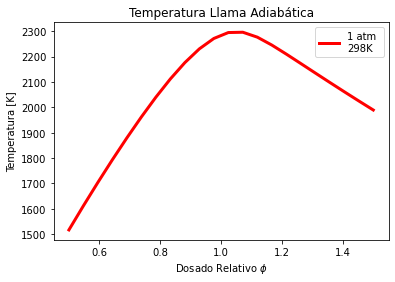

In [26]:
phi_lista=np.linspace(0.5,1.5,22)
T=[]
gas3 = ct.Solution('nDodecane_Reitz.cti', 'nDodecane_IG')
for i in phi_lista:
    gas3.TPX = temp, press,composition_CxHyOz_Air(gas1, fuel_species,fracc_fuel, 1/i)[0][0]
    gas3.equilibrate('HP')
    T.append(gas3.T)
    
plt.plot(phi_lista,T,label='1 atm \n298K',linewidth=3,color='red')
plt.title('Temperatura Llama Adiabática')
plt.xlabel(r'Dosado Relativo $\phi$')
plt.ylabel('Temperatura [K]')
plt.legend()
plt.savefig('Grafica_LLama_Adiabatica.png')
plt.show()  

## Índice de Wobbe

$W = HHV /\sqrt{d}$

$W_{mix} = \frac{\sum x_iHHV_{v,i}}{\sqrt{\sum x_id_i}}$

In [10]:
import math

HHV_v_H2 = 11.966
HHV_v_C12H26 = 343.072
W_mix = (0.9*HHV_v_C12H26+0.1*HHV_v_H2)/(math.sqrt(0.9*d_C12H26+0.1*d_H2))
print(f"El índice de Wobbe de la mezcla es: {W_mix:.2f} MJ/m3")

El índice de Wobbe de la mezcla es: 134.86 MJ/m3


## Temperatura de rocío

Para hallar la temperatura de rocío debemos hallar en un principio la presión parcial del $H_2O$ en los productos. Posteriormente buscamos la temperatura de inicio de la condensación para dicha presión.

In [16]:
p_productos = 101325 #Pa, pues se asume que los productos salen a condiciones estándar 
n_productos = 85.39
n_H2O = 11.8
P_parcial_H2O = (n_H2O/n_productos)*p_productos
w = ct.Water()
w.PX = P_parcial_H2O, 1
T_rocio = w.T
print(f"La temperatura de rocío es: {T_rocio:.2f} K")

La temperatura de rocío es: 325.75 K


## Factor de emisión de CO2

Para hallar el factor de emisión, debemos hallar la masa de CO2 producida en la reacción y posteriormente dividirla por el poder calorífico inferior másico.

$m_{CO_2}=\frac{M_{CO_2}n_{CO_2}}{n_{C_{12}H{26}}M_{C_{12}H{26}}+n_{H_2}M_{H_2}}$

$Fe=\frac{m_{CO_2}}{LHV_m}$

In [12]:
m_CO2 = (44*10.8)/(170*0.9+2*0.1)
Fe = m_CO2/(LHV_m*1e-6)
print(f"El factor de emisión de CO2 es de {Fe:.2f} kg_CO2/TJ_LHV")

El factor de emisión de CO2 es de 69596.17 kg_CO2/TJ_LHV


## Reducción de aire respecto a diesel puro

Para hallar el porcentaje de reducción de aire respecto a la condición de diésel puro, se toman los valores de las moles de aire para la dos condiciones, diésel puro y la mezcla diésel-Hidrógeno.

$C_{12}H_{26}+18.5(O_2+3.76N_2)\rightarrow 12CO_2+13H_2O+69.56N_2$

$(0.9C_{12}H_{26}+0.1H_2)+16.7(O_2+3.76N_2)\rightarrow 10.8CO_2+11.8H_2O+62.79N_2$

Posteriormente, se restan las dos cantidades y se divide el resultado por las moles de aire en el caso del diésel puro.

$\%reduccion-aire = \frac{18.5-16.7}{18.5}100\%$


In [13]:
red_air = (18.5-16.70)/18.5*100
print(f"El porcentaje de reducción de aire respecto al caso de diésel puro es: {red_air:.2f}%")

El porcentaje de reducción de aire respecto al caso de diésel puro es: 9.73%


## Botellas de agua que se pueden llenar quemando 1000 kg de combustible

En primer lugar, debemos calcular el número de moles a los que corresponden 1000 kg de combustible, para esto utilizamos la ecuación $m=n*M$.

$n:$ Es el número de moles [kmol]

$m:$ Es la masa [kg]

$M:$ Es el peso molecular [kg/kmol]

El número de moles que nos arroje el cálculo, multiplicará las moles de combustible:

$6.53(0.9C_{12}H_{26}+0.1H_2)+a(O_2+3.76N_2)\rightarrow bCO_2+cH_2O+dN_2$

$C: 6.53(0.9)(12)=b$

$H: 6.53(0.9(26)+0.1(2))=c(2)$

$O: a(2)=b(2)+c$

$N: a(3.76)(2)=d(2)$

$6.53(0.9C_{12}H_{26}+0.1H_2)+109.1(O_2+3.76N_2)\rightarrow 70.52CO_2+77.05H_2O+410N_2$

Nuevamente se balancea la ecuación y se calcula la masa de agua que se obtiene de realizar la combustión. Finalmente se tiene que quemando 1000 kg de combustible, se obtienen 1386 botellas de agua.

In [14]:
n_fuel = 1000/(170*0.9+2*0.1)

n_H2O = 77.05 #kmol
M_H2O = 18 #kg/kmol
m_H2O = n_H2O*M_H2O
rho_H2O = 1 #kg/lt 
v_H2O = m_H2O/rho_H2O
print("El número de botellas que se pueden llenar quemando 1000 kg de combustible es: {}" .format(v_H2O//1))


El número de botellas que se pueden llenar quemando 1000 kg de combustible es: 1386.0


## Setup para un quemador de coflujo (llama no-premezclada)

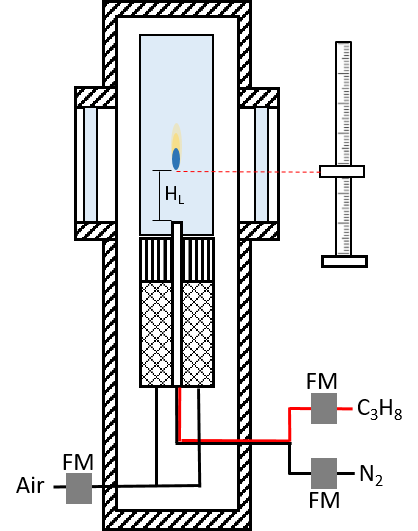